In [5]:
%matplotlib notebook

import numpy as np
import scipy.optimize as scyopt
import scipy.stats as scystat
# import gpy
import matplotlib.pyplot as mplt
from matplotlib.animation import FuncAnimation
from ipywidgets import interact, interact_manual

# print(mplt.rcParams.keys())
mplt.rcParams.update({
    'font.size':18, 'axes.grid': True, 'grid.alpha': 0.5,
    'grid.linestyle': '--', 'grid.linewidth': 1, 'lines.linewidth': 2})

In [6]:
def calc_cov(x, leng=1, sigma=1):
    x = x/leng
    dx = x[:, None] - x[None, :]
    return sigma*np.exp(-dx*dx/2)

# Bayes Theorem and Bayesian Inference

Suppose we have a physical quantity $Y$ whose value we don't know but we think it is distributed normally with $\sigma=3$. Since we don't know the value, we assume $\mu=0$. The PDF of this variable is given by:

$$P(Y|\mu=0,\sigma=3) = \mathcal{N}(0,3) = \frac{1}{3\sqrt{2\pi}}\exp\left(-\frac12\frac{Y^2}{3^2}\right)$$

<IPython.core.display.Javascript object>


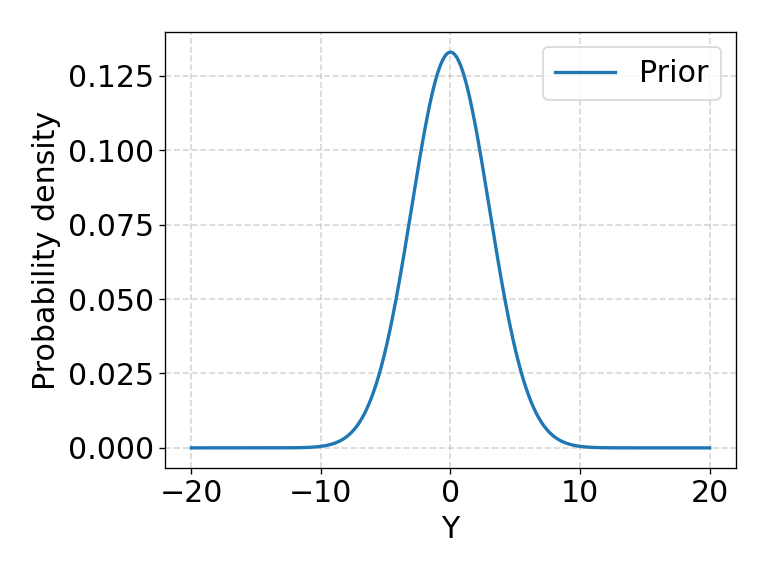

In [7]:
# Code made by chatgpt with a few modifications

# Define the prior mean and standard deviation
mu_0 = 0
sigma_0 = 3

# Define a range of X values
X = np.linspace(-20, 20, 10000)

# Calculate the prior PDF
prior_pdf = scystat.norm.pdf(X, mu_0, sigma_0)

# Plot the prior PDF
fig, ax = mplt.subplots(1, 1)
ax.plot(X, prior_pdf, label='Prior')
ax.set_xlabel('Y')
ax.set_ylabel('Probability density')
ax.legend(loc='best')
fig.tight_layout()
fig.show()

Now suppose we make a measurement $y_0$ of this quantity and the value is $5$. The measurement procedure has an uncertainty whose standard deviation is $1$. We could say that the result of the measurement also is a gaussian:

$$P(y_0|Y, \mu_0=5, \sigma_0=1) = \mathcal{N}(5, 1) = \frac{1}{1\sqrt{2\pi}}\exp\left(-\frac12\frac{(y_0-5)^2}{1^2}\right)$$

we can use Bayes Theorem to update our beliefs given this new information:

$$P(Y|y_0) = \frac{P(y_0|Y)P(Y)}{P(y_0)}$$

where :
 - $P(Y|y_0)$ is called the posterior, because it represents our updated beliefs on $Y$ after the measurement;
 - $P(Y)=P(Y|\mu,\sigma)$ is our prior assumption;
 - $P(y_0|Y)$ called likelihood, which in our case is the measurement information;
 - $P(y_0)$ is the probability of having measured $y_0$ (marginal likelihood) which here we can consider just as a normalization constant

In [15]:
def make_animation(frames, mu_x, sigma_x, x, prior):
    post_pdf = prior.copy()

    # Plot the prior PDF
    fig, ax = mplt.subplots(1, 1)
    ax.plot(X, prior, label='Prior')
    ax.set_xlabel('Y')
    ax.set_ylabel('Probability density')
    ax.legend(loc='best')
    fig.tight_layout()

    line, = ax.plot([0], [0])
    lines = ax.plot([0], np.array([[0]]*len(frames)).T)
    for l in lines:
        l.set_visible(False)
    def update(i, post):
        mux = mu_x[i]
        sigx = sigma_x[i]
        # Calculate the likelihood PDF
        likelihood_pdf = scystat.norm.pdf(x, mux, sigx)

        # Plot the likelihood PDF
        lines[i].set_data(x, likelihood_pdf)
        lines[i].set_label(f'y{i:d}~N({mux:.1f},{sigx:.1f})')
        lines[i].set_visible(True)

        # Multiply the prior PDF and the likelihood PDF to 
        # get the unnormalized posterior PDF
        post *= likelihood_pdf

        # Normalize the unnormalized posterior PDF
        norm_constant = np.trapz(post, x)
        post /= norm_constant

        # Plot the posterior PDF
        line.set_data(x, post)
        line.set_label(f'Posterior {i:d}')
        ax.legend(loc='best', fontsize='x-small')
        ax.relim()
        ax.autoscale_view()
        fig.tight_layout()
        return []

    return FuncAnimation(
        fig, update, fargs=(post_pdf, ), frames=frames,
        repeat=False, repeat_delay=2, interval=4000, init_func=lambda: [])

In [19]:
# Define the measurement mean and standard deviation
mu_x = [5, 1, 3, 2, 3.5]
sigma_x = [1, 4, 1.5, 2, 0.5]
frames = list(range(len(mu_x)))

<IPython.core.display.Javascript object>


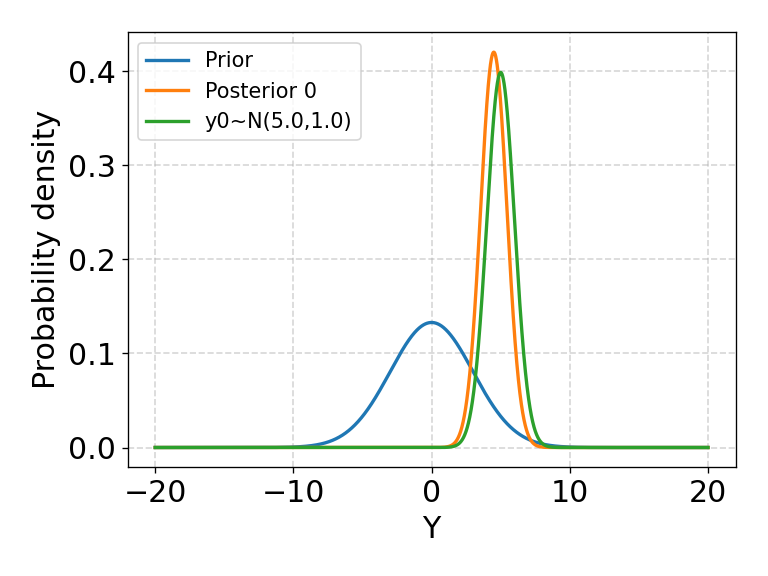

In [20]:
anim = make_animation(frames[:1], mu_x, sigma_x, X, prior_pdf)

If more data is measured our beliefs can be updated considering the previous posterior distribution as prior:

$$P(Y|\{y_0,y_1\}) = \frac{P(y_1|Y)P(Y|y_0)}{P(y_1)} = \frac{P(y_1|Y)P(y_0|Y)P(Y)}{P(y_1)P(y_0)}$$

This process can be repeated indefinetly considering new measurements are made:

$$P(Y|\mathcal{D}) = \frac{\prod_\mathcal{D}P(y_i|Y)}{\prod_\mathcal{D}P(y_i)}P(Y), \quad \mathcal{D}=\{y_i| i=0..N\} \quad\mathrm{and}\quad y_i \sim \mathcal{N}(\mu_i, \sigma_i)$$

<IPython.core.display.Javascript object>


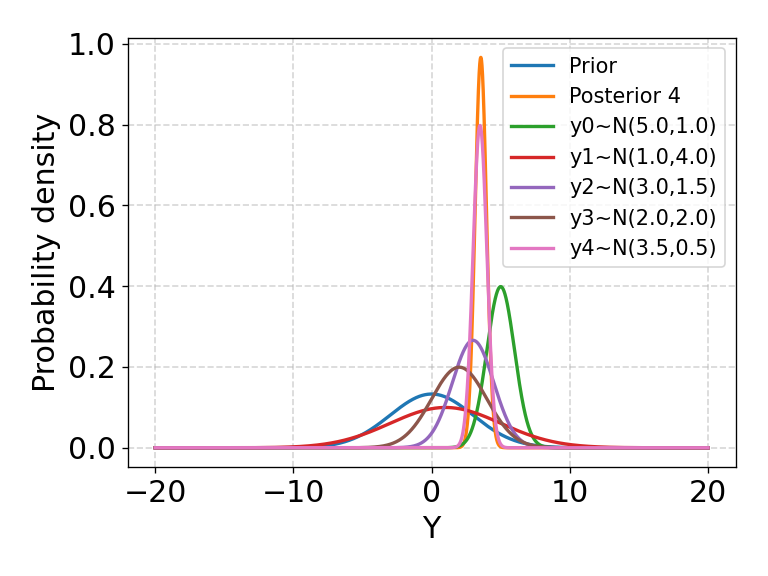

In [21]:
anim = make_animation(frames, mu_x, sigma_x, X, prior_pdf)

It is worth noticing that the final posterior does not depend on the order of the new data:

<IPython.core.display.Javascript object>


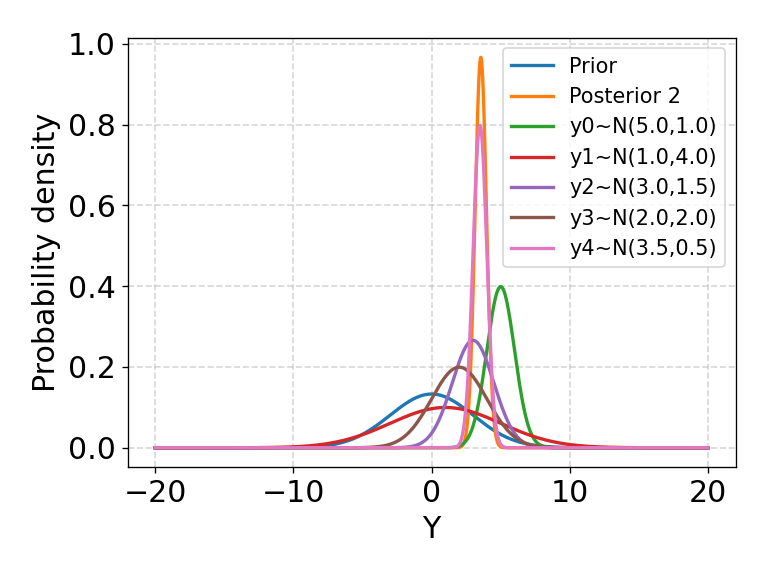

In [23]:
anim2 = make_animation(
    np.random.permutation(frames), mu_x, sigma_x, X, prior_pdf)

As an example let's see how we could use the 

$$ f(x) = w_1 + w_2x = (w_1,w_2)(1,x)^T$$

In [26]:
# Prior on omega
F = 2
phi = lambda x: x[:, None]**(np.arange(F)[None, :])
mu = np.zeros((F, 1))
sigma = np.eye(F)

# Prior of f(x)
n = 100
x = np.linspace(-6, 6, n)
phix = phi(x)
m = phix @ mu
kxx = phix @ sigma @ phix.T


# Made up data
N = 10
sig_err = 1
X = np.random.rand(N) * 6
Y = 1 + 2*X + np.random.randn(*X.shape)*sig_err

# prior on Y = f(x) + epsilon
phiX = phi(X)
M = phiX @ mu
kXX = phiX @ sigma @ phiX.T

# Posterior:
kXXi = np.linalg.inv(kXX + np.eye(X.size)*sig_err**2)
kxX = phix @ sigma @ phiX.T
mu_post = mu + sigma @ phiX.T @ kXXi @ (Y[:, None]-M)
m_post = phix @ mu_post
# m_post = m + kxX @ kXXi @ (Y[:, None] - M) # This is another way of calculating it

sigma_post = sigma - sigma @ phiX.T @ kXXi @ phiX @ sigma
kxx_post = phix @ sigma_post @ phix.T
# kxx_post = kxx - kxX @ kXXi @ kxX.T  # This is another way of calculating it
smpl = np.random.multivariate_normal(m_post.ravel(), kxx_post, size=4)

<IPython.core.display.Javascript object>


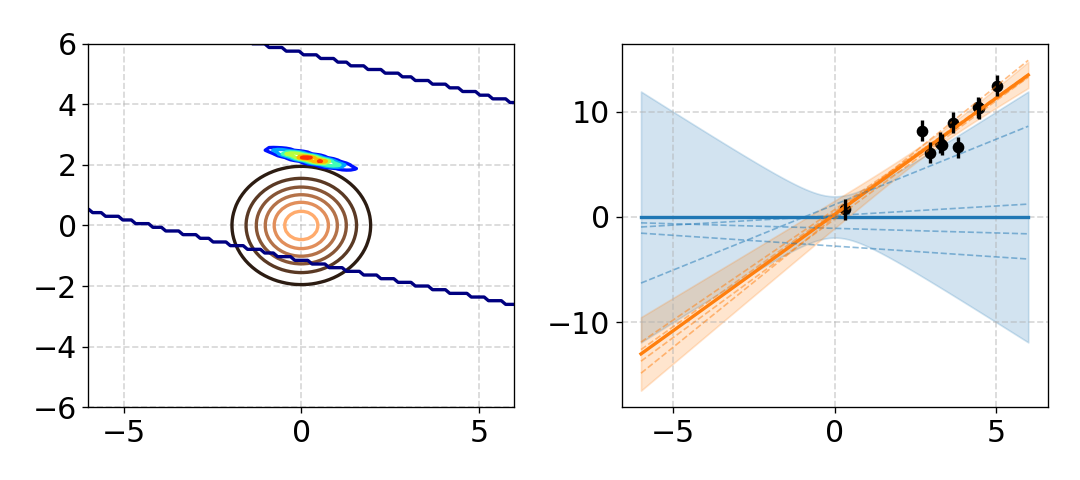

In [27]:
fig, (ax, ay) = mplt.subplots(1, 2, figsize=(9,4))

xgrid = np.linspace(-6, 6, 100)
xgrid, ygrid = np.meshgrid(xgrid, xgrid)
pos = np.empty(xgrid.shape + (2, ))
pos[:, :, 0] = xgrid
pos[:, :, 1] = ygrid

pdf_prior = scystat.multivariate_normal.pdf(pos, mu.ravel(), sigma)
pdf_post = scystat.multivariate_normal.pdf(pos, mu_post.ravel(), sigma_post)

w_prior = np.random.multivariate_normal(mu.ravel(), sigma, size=4)
fx_prior = phix @ w_prior.T
std_prior = np.sqrt(np.diag(kxx))

w_post = np.random.multivariate_normal(mu_post.ravel(), sigma_post, size=4)
fx_post = phix @ w_post.T
std_post = np.sqrt(np.diag(kxx_post))

ax.contour(xgrid, ygrid, pdf_prior/pdf_prior.max()*pdf_post.max(), cmap='copper')
ax.contour(xgrid, ygrid, pdf_post, cmap='jet')

ay.plot(x, m.ravel())
ay.plot(x, m_post.ravel())
ay.plot(x, fx_prior, '--', alpha=0.5, color='C0', lw=1)
ay.plot(x, fx_post, '--', alpha=0.5, color='C1', lw=1)
ay.fill_between(x, m.ravel()+1.96*std_prior, m.ravel()-1.96*std_prior, color='C0', alpha=0.2)
ay.fill_between(x, m_post.ravel()+1.96*std_post, m_post.ravel()-1.96*std_post, color='C1', alpha=0.2)
ay.errorbar(X, Y, yerr=sig_err, linestyle='', marker='o', color='k', barsabove=True)

fig.tight_layout()
fig.show()

# Introduction: Multivariate Gaussian

The multivariate gaussian is the extension of the gaussian distribution to higher dimensions. It can be used to model the joint probability distribution of $N$ random variables $Y_i$, which may be thought of as a vector in $\mathbf{Y}\in \mathbb{R}^N$, : 

$$\mathbf{Y} \sim N(\mathbf{\mu}, \mathbf{\Sigma}) = \frac{1}{\sqrt{(2\pi)^k|\mathbf{\Sigma}|}}\exp\left(-\frac12(\mathbf{Y}-\mathbf{\mu})^T\mathbf{\Sigma}^{-1}(\mathbf{Y}-\mathbf{\mu})\right)$$

This distribution is completely characterized by the vector mean $\mathbf{\mu}\in\mathbb{R}^N$ and the correlation matrix $\mathbf{\Sigma}\in\mathbb{R}^N\times\mathbb{R}^N$.

<IPython.core.display.Javascript object>


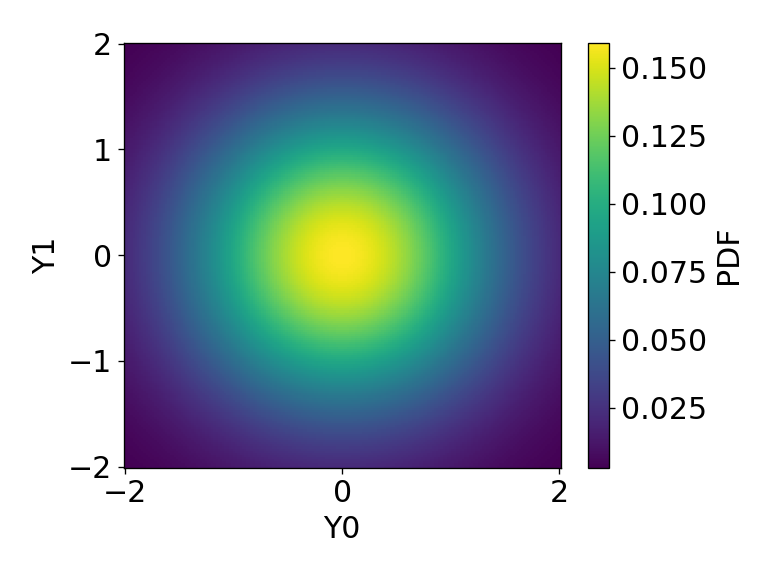

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [29]:
fig, ax = mplt.subplots(1, 1)
ax.set_ylabel('Y1')
ax.set_xlabel('Y0')
ax.grid(False)

# Define the grid of x and y values
y1 = np.linspace(-2, 2, 200)
y1, y2 = np.meshgrid(y1, y1)
pos = np.empty(y1.shape + (2,))
pos[:, :, 0] = y1
pos[:, :, 1] = y2

mean = np.array([0.0, 0.0])
pos -= mean

surf = ax.pcolormesh(y1, y2, y2)
fig.colorbar(surf, label='PDF')

@interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    # Code done by chatgpt with a few modifications

    # Define the covariance of the distribution
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation

    # Calculate the inverse of the covariance matrix
    covi = np.linalg.inv(cov)

    # Calculate the multivariate Gaussian distribution
    
    z = np.exp(-1/2 * np.sum(pos @ covi * pos, axis=-1))
    z *= 1/np.sqrt((2*np.pi)**2 * np.linalg.det(cov))

    surf.set_array(z)
    surf.set_clim([z.min(), z.max()])
    fig.tight_layout()

<IPython.core.display.Javascript object>


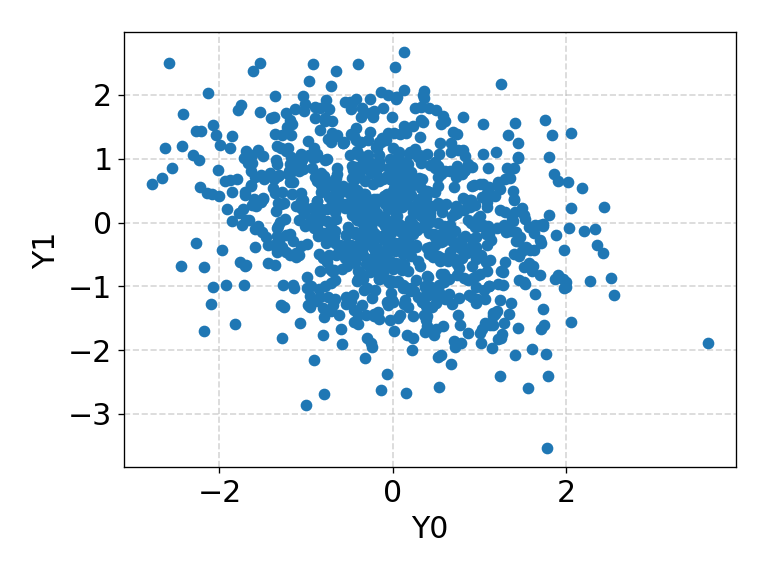

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [30]:
fig, ax = mplt.subplots(1, 1)
line, = ax.plot([0], [0], 'o')
ax.set_ylabel('Y1')
ax.set_xlabel('Y0')

@interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    x = np.linspace(0, 1, 2)
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=1000)
    line.set_data(data[:, 0], data[:, 1])
    ax.relim()
    ax.autoscale_view()
    fig.tight_layout()

<IPython.core.display.Javascript object>


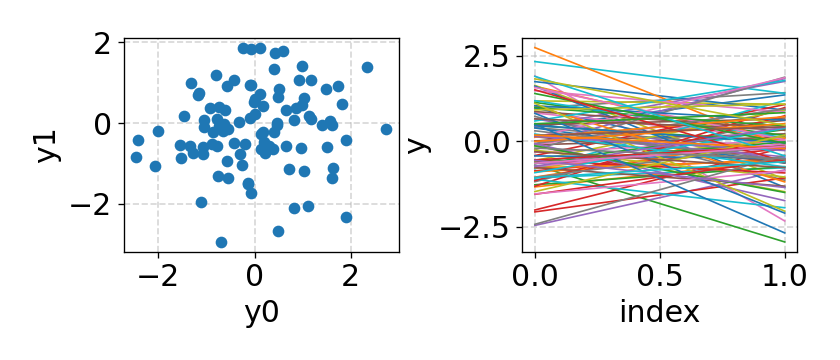

interactive(children=(FloatSlider(value=0.0, description='correlation', max=0.99, min=-0.99, step=0.01), Outpu…

In [34]:
fig, (ay, ax) = mplt.subplots(1, 2, figsize=(7, 3))
ax.set_ylabel('y')
ax.set_xlabel('index')

line, = ay.plot([0], [0], 'o')
ay.set_ylabel('y1')
ay.set_xlabel('y0')

@interact
def plot_gauss(correlation=(-0.99, 0.99, 0.01)):
    [l.remove() for l in ax.lines]
    x = np.linspace(0, 1, 2)
    cov = np.eye(2)
    cov[0, 1] = correlation
    cov[1, 0] = correlation
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=100)
    ax.plot(x, data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    line.set_data(data[:, 0], data[:, 1])
    ay.relim()
    ay.autoscale_view()
    fig.tight_layout()

<IPython.core.display.Javascript object>


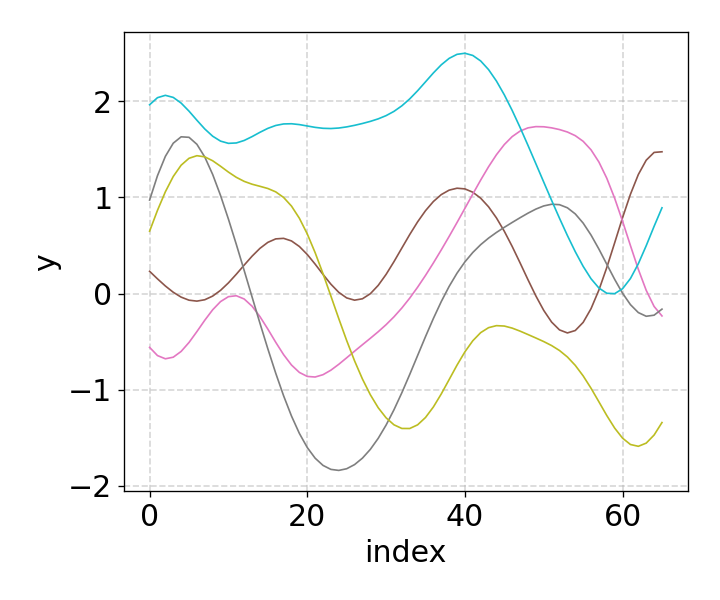

interactive(children=(FloatSlider(value=0.001, description='correlation', max=0.999, min=0.001, step=0.01), In…

In [33]:
fig, ax = mplt.subplots(1, 1, figsize=(6, 5))
ax.set_ylabel('y')
ax.set_xlabel('index')

@interact(correlation=(0.001, 0.999, 0.01), ndim=(2, 100, 1), ncurves=(1, 50, 1))
def plot_gauss(correlation=0.001, ndim=2, ncurves=5):
    [l.remove() for l in ax.lines]
    x = np.arange(ndim)
    cov = calc_cov(x, leng=2**2/2/np.sqrt(-np.log(correlation)))
    mean = np.zeros(x.size)
    data = np.random.multivariate_normal(mean, cov, size=ncurves)
    ax.plot(x, data.T, lw=1)
    ax.relim()
    ax.autoscale_view()
    fig.tight_layout()